2. You will apply ML classification models such as logistic regression, Support Vector Machine (SVM), or  Naive Bayes (NB). Optionally, you are also welcomed to try other classifiers not used in the paper, such as Random Forest (RF) to see whether it outperformed the existing results.
2 Ans:- Please run the below code to get output for comparission of various models;

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\puppa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\puppa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\puppa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


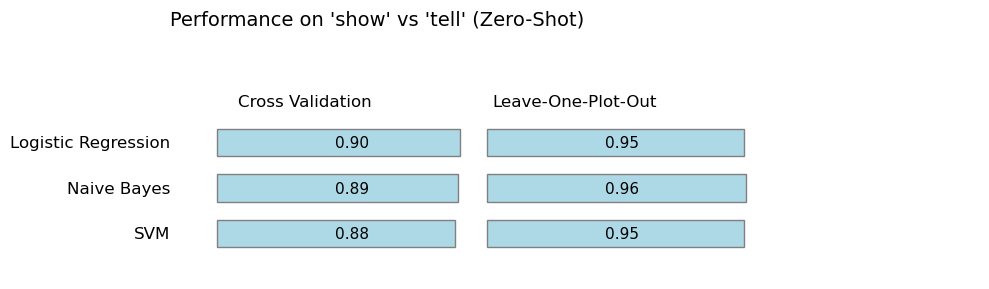

In [15]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load and preprocess
file_path = "https://raw.githubusercontent.com/UB01976/is7332025/refs/heads/main/data-mining-project-repo/04282025_CW/data_stories_one_shot.csv"
df = pd.read_csv(file_path) 

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['processed'] = df['Sentence'].apply(preprocess)
df = df[df['Stage'].isin([1, 2, 3])].dropna(subset=['processed', 'Plot_Name'])
df['label'] = df['Stage'].apply(lambda x: 0 if x == 1 else 1)

# TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['processed'])
y = df['label'].values
groups = df['Plot_Name'].values

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True)
}

# Cross-validation and LOPO
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = pd.DataFrame(index=models.keys(), columns=['Cross Validation', 'Leave-One-Plot-Out'])

for name, model in models.items():
    aucs = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    results.loc[name, 'Cross Validation'] = np.mean(aucs)

logo = LeaveOneGroupOut()
for name, model in models.items():
    aucs = []
    for train_idx, test_idx in logo.split(X, y, groups):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict_proba(X[test_idx])[:, 1]
        if len(np.unique(y[test_idx])) > 1:
            aucs.append(roc_auc_score(y[test_idx], y_pred))
    results.loc[name, 'Leave-One-Plot-Out'] = np.mean(aucs)

results = results.astype(float).round(2)

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

col_labels = results.columns.tolist()
row_labels = results.index.tolist()
cell_values = results.values

n_rows, n_cols = cell_values.shape
bar_color = '#add8e6'

cell_height = 0.5
cell_width = 2

for col_idx, label in enumerate(col_labels):
    ax.text((col_idx + 1) * cell_width - 1, (n_rows + 0.5) * cell_height + 0.2,
            label, ha='center', va='center', fontsize=12)

for row_idx, row_label in enumerate(row_labels):
    y = (n_rows - row_idx) * cell_height
    ax.text(0, y, row_label, ha='right', va='center', fontsize=12)
    for col_idx in range(n_cols):
        x = (col_idx + 1) * cell_width - 0.65
        val = cell_values[row_idx, col_idx]
        bar_length = val * cell_width 
        ax.barh(y=y, width=bar_length, height=cell_height * 0.6,
                left=x - cell_width / 2, color=bar_color, edgecolor='gray')
        ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=11, color='black')

plt.title("Performance on 'show' vs 'tell' (Zero-Shot)", fontsize=14, pad=20, loc='left')
plt.xlim(0, (n_cols + 1) * cell_width)
plt.ylim(0, (n_rows + 2) * cell_height)
plt.tight_layout()
plt.show()